In [1]:
import sys
from pathlib import Path
from typing import Any, Callable, Dict, Tuple

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_ent_16_more/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)

        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.initialize_weights(w_std=0.01)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim, hidden_width=conditioner_width)

    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.01, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=W.dtype, device=W.device)
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(v @ W + c).sum(dim=-1)
        return term1 - term2

    def _compute_effective_biases(self, cond: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b # unsqueeze for broadcasting
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        v_next = torch.bernoulli(p_v, generator=rng)
        return v_next

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        fe = self._free_energy(v, self.W, b_mod, c_mod)
        return -0.5 * fe / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch
        v_data = values.to(dtype=self.W.dtype, device=self.W.device)
        cond = cond.to(v_data.device, dtype=v_data.dtype)

        rng = aux_vars.get("rng", torch.Generator(device="cpu"))
        l2_strength = float(aux_vars.get("l2_strength", 0.0))
        noise_frac = float(aux_vars.get("noise_frac", 0.05))

        b_mod, c_mod = self._compute_effective_biases(cond)
        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        v_model = v_data.clone()
        batch_size = v_data.shape[0]
        n_noise = int(batch_size * noise_frac)
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)
        v_model = v_model.detach()

        n_flips = (v_data != v_model).float().sum()
        flip_rate = n_flips / v_data.numel()
        max_bias = torch.max(torch.abs(b_mod)).detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_diff = fe_data - fe_model

        loss = fe_diff.mean() + l2_strength * l2_reg

        return loss, {
            "flip_rate": flip_rate,
            "max_bias": max_bias,
            "free_energy_mean": fe_diff.mean().detach(),
            "free_energy_std": fe_diff.std(unbiased=False).detach()
        }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.view(-1, self.cond_dim)
        cond = cond.to(self.W.device, dtype=torch.float32)

        b_mod, c_mod = self._compute_effective_biases(cond)
        B = cond.shape[0]

        v = (torch.rand((B, self.num_visible), generator=rng, device=cond.device) < 0.5).float()

        if T_schedule.dim() == 0: T_schedule = T_schedule.view(1)

        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)
        return v

In [3]:

def compute_renyi_entropy(samples: torch.Tensor, subs_size: int,
                          log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> float:

    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return 0.0

    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]

    ref_1_score = log_score_fn(ref_1)
    ref_2_score = log_score_fn(ref_2)

    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]

    swap_1_score = log_score_fn(swap_1)
    swap_2_score = log_score_fn(swap_2)

    log_swap_ratio = swap_1_score + swap_2_score - ref_1_score - ref_2_score
    swap_exp = torch.exp(log_swap_ratio).mean().item()

    if swap_exp <= 1e-12:
        return 0.0

    renyi_entropy = -math.log(swap_exp)
    return renyi_entropy


def monitor_entropy(model, device, chain_len, monitor_seed=1234, n_samples=2000):
    model.eval()

    cond_val = 1.0
    cond_gen = torch.tensor([[cond_val]], device=device).expand(n_samples, -1)
    cond_score = torch.tensor([[cond_val]], device=device)

    T_schedule = torch.full((model.k,), model.T, device=device)
    rng = torch.Generator(device=device).manual_seed(monitor_seed)
    samples = model.generate(cond_gen, T_schedule, rng)

    scorer = lambda v: model.log_score(v, cond_score)
    half_chain = chain_len // 2
    s2 = compute_renyi_entropy(samples, half_chain, scorer)

    model.train()
    return s2

In [4]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int,
          rng: torch.Generator, monitor_seed: int, l2_strength: float, noise_frac: float,
          lr_schedule_fn: Callable[[int], float], ds: MeasurementDataset):

    metrics: Dict[int, Any] = {}
    global_step = 0
    device = next(model.parameters()).device
    chain_length = ds.num_qubits

    header = f"{'Epoch':<6} | {'Loss':<9} | {'FE Mean':<8} | {'FE Std':<8} | {'LR':<8} | {'S2(L/2)':<8}"
    print(header)
    print("-" * len(header))

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean = 0.0
        fe_std = 0.0

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength, "noise_frac": noise_frac }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean = float(aux_out.get("free_energy_mean", 0.0))
            fe_std = float(aux_out.get("free_energy_std", 0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        s2_curr = monitor_entropy(model, device, chain_length, monitor_seed=monitor_seed)

        metrics[epoch] = {
            'loss': avg_loss,
            'free_energy_mean': fe_mean,
            'free_energy_var': fe_std,
            'lr': lr_epoch,
            's2': s2_curr
        }

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | {fe_mean:+.4f}   | {fe_std:.4f}   | "
              f"{lr_epoch:.5f}  | {s2_curr:.4f}")

    return model, metrics

In [5]:
CHAIN_LENGTH = 16
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 10_000

#h_support = [0.80, 1.00, 1.20]
h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]


file_names = [f"tfim_{CHAIN_LENGTH}_h{d:.2f}_{FILE_SAMPLES}.npz" for d in h_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

print(f"System Size       : {CHAIN_LENGTH} spins (1D Chain)")
print(f"Support h         : {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=samples_per_file)

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 16 spins (1D Chain)
Support h         : [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
Samples Shape     : (70000, 16)
Conditions Shape  : (70000, 1)


In [10]:
# TRAINING CONFIG

batch_size        = 1024
num_visible       = ds.num_qubits

num_hidden        = 16
conditioner_width = 32  # increasing to 64 does not help much
l2_strength       = 0.0
num_epochs        = 200 # should be larger
k_steps           = 30  # works with only 15 too
init_lr           = 1e-2
final_lr          = init_lr * 0.01
noise_frac        = 1.0

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

model.initialize_weights(w_mean=0.0, w_std=0.01, bias_val=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.001)

print(f"Training on {num_visible} qubits for {num_epochs} epochs (k={k_steps})...")

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       rng=rng, monitor_seed=SEED, l2_strength=l2_strength, noise_frac=noise_frac,
                       lr_schedule_fn=lr_schedule_fn, ds=ds)

Training on 16 qubits for 200 epochs (k=30)...
Epoch  | Loss      | FE Mean  | FE Std   | LR       | S2(L/2) 
--------------------------------------------------------------
1      | -0.0870   | +0.1740   | 4.7326   | 0.00999  | 0.4346
2      | -0.3499   | -0.6816   | 4.4437   | 0.00999  | 0.6806
3      | -0.1696   | +0.0123   | 4.3941   | 0.00999  | 0.6712
4      | -0.0749   | -0.2935   | 4.0693   | 0.00999  | 0.7055
5      | -0.0208   | +0.1927   | 4.4216   | 0.00999  | 0.7002
6      | -0.0192   | +0.0957   | 4.1550   | 0.00998  | 0.6678
7      | -0.1314   | -0.3608   | 3.7253   | 0.00998  | 0.6601
8      | -0.1375   | -0.2515   | 3.7382   | 0.00998  | 0.4742
9      | -0.0745   | -0.2112   | 4.3200   | 0.00998  | 0.5324
10     | -0.0409   | +0.1119   | 4.0258   | 0.00998  | 0.6775
11     | -0.0531   | +0.4131   | 3.9107   | 0.00998  | 0.5863
12     | -0.0340   | -0.1003   | 3.9098   | 0.00998  | 0.5864
13     | -0.0357   | -0.0484   | 3.8282   | 0.00998  | 0.5622
14     | -0.0558   | 

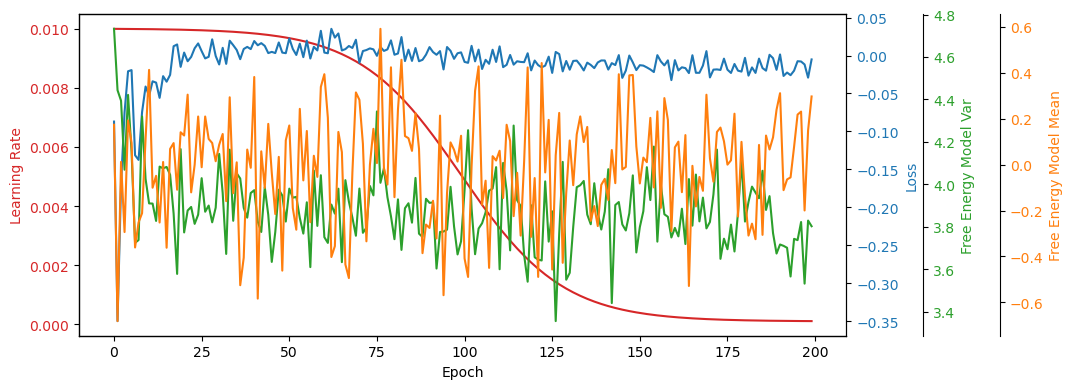

In [11]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [12]:
#h_eval_values = [0.8, 1.0, 1.2]
h_eval_values = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]

eval_samples = 20_000
eval_steps = 200
T_eval = 1.0

l_axis_ref = list(range(1, CHAIN_LENGTH // 2 + 1))

rbm_data = {}
rng_eval = torch.Generator(device=next(model.parameters()).device).manual_seed(1234)

print("=== RENYI ENTROPY RECONSTRUCTION ===")

for h_val in h_eval_values:
    print(f"Processing h = {h_val}...")

    # 1. Generate
    cond_gen = torch.tensor([[h_val]], device=next(model.parameters()).device).expand(eval_samples, -1)
    T_schedule = torch.full((eval_steps,), T_eval, device=cond_gen.device)

    with torch.no_grad():
        samples = model.generate(cond_gen, T_schedule, rng_eval)

    # 2. Score
    cond_score = torch.tensor([[h_val]], device=next(model.parameters()).device)
    scorer = lambda v: model.log_score(v, cond_score)

    # 3. Compute
    curve = []
    for l in l_axis_ref:
        s2 = compute_renyi_entropy(samples, l, scorer)
        curve.append(s2)

    rbm_data[h_val] = curve
    print(f" -> {[round(x, 4) for x in curve]}")

=== RENYI ENTROPY RECONSTRUCTION ===
Processing h = 0.5...
 -> [0.6204, 0.6875, 0.6937, 0.6961, 0.6952, 0.6952, 0.695, 0.6943]
Processing h = 0.8...
 -> [0.5206, 0.6309, 0.6682, 0.6878, 0.7037, 0.7015, 0.7164, 0.7064]
Processing h = 0.95...
 -> [0.3904, 0.4914, 0.5335, 0.5401, 0.6067, 0.6289, 0.6607, 0.6472]
Processing h = 1.0...
 -> [0.3281, 0.4317, 0.4765, 0.5188, 0.5381, 0.5464, 0.5775, 0.5549]
Processing h = 1.05...
 -> [0.2936, 0.3491, 0.4133, 0.4189, 0.4482, 0.4818, 0.5082, 0.4894]
Processing h = 1.2...
 -> [0.1869, 0.217, 0.2432, 0.2577, 0.2757, 0.2703, 0.2979, 0.2778]
Processing h = 1.5...
 -> [0.1552, 0.1738, 0.1793, 0.1847, 0.1936, 0.1689, 0.1983, 0.1786]


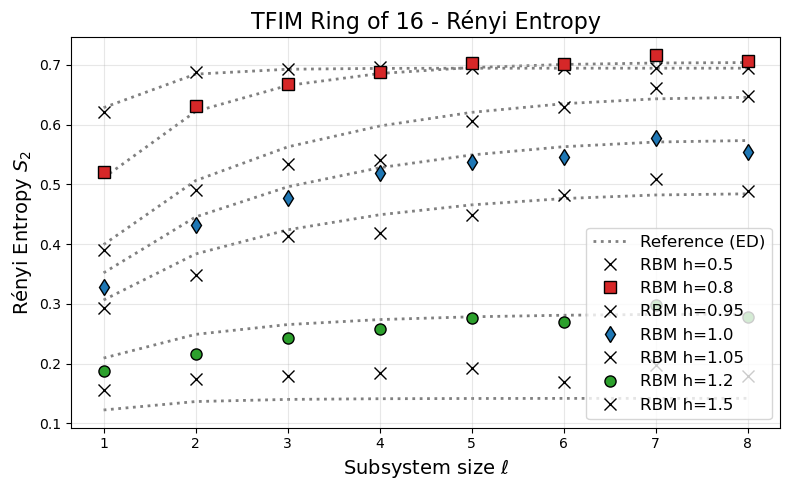

In [13]:
chain_length = CHAIN_LENGTH
ref_file = Path(f"tfim_{chain_length}_entropy_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

l_axis_ref = []
l_cols = []
if ref_df is not None:
    l_cols = sorted([c for c in ref_df.columns if c.startswith("l")], key=lambda s: int(s[1:]))
    l_axis_ref = [int(c[1:]) for c in l_cols]
else:
    l_axis_ref = list(range(1, chain_length // 2 + 1))

styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

#### PLOTTING ####

plt.figure(figsize=(8, 5))

ref_label_added = False

sorted_h = sorted(rbm_data.keys())

for h in sorted_h:
    st = styles.get(h, {'color': 'black', 'fmt': 'x', 'label': f'h={h}'})

    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            plt.plot(l_axis_ref, y_ref, ':', color='gray', linewidth=2.0,
                     label=lbl, zorder=1)
            ref_label_added = True

    s2_vals = rbm_data[h]
    l_rbm = range(1, len(s2_vals) + 1)
    plt.plot(l_rbm, s2_vals, marker=st['fmt'], linestyle='None', color=st['color'], markersize=8,
             markeredgecolor='k', label=f"RBM {st['label']}", zorder=2)


plt.xlabel("Subsystem size $\\ell$", fontsize=14)
plt.ylabel(r"Rényi Entropy $S_2$", fontsize=14)
plt.title(f"TFIM Ring of {chain_length} - Rényi Entropy", fontsize=16)

plt.legend(frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

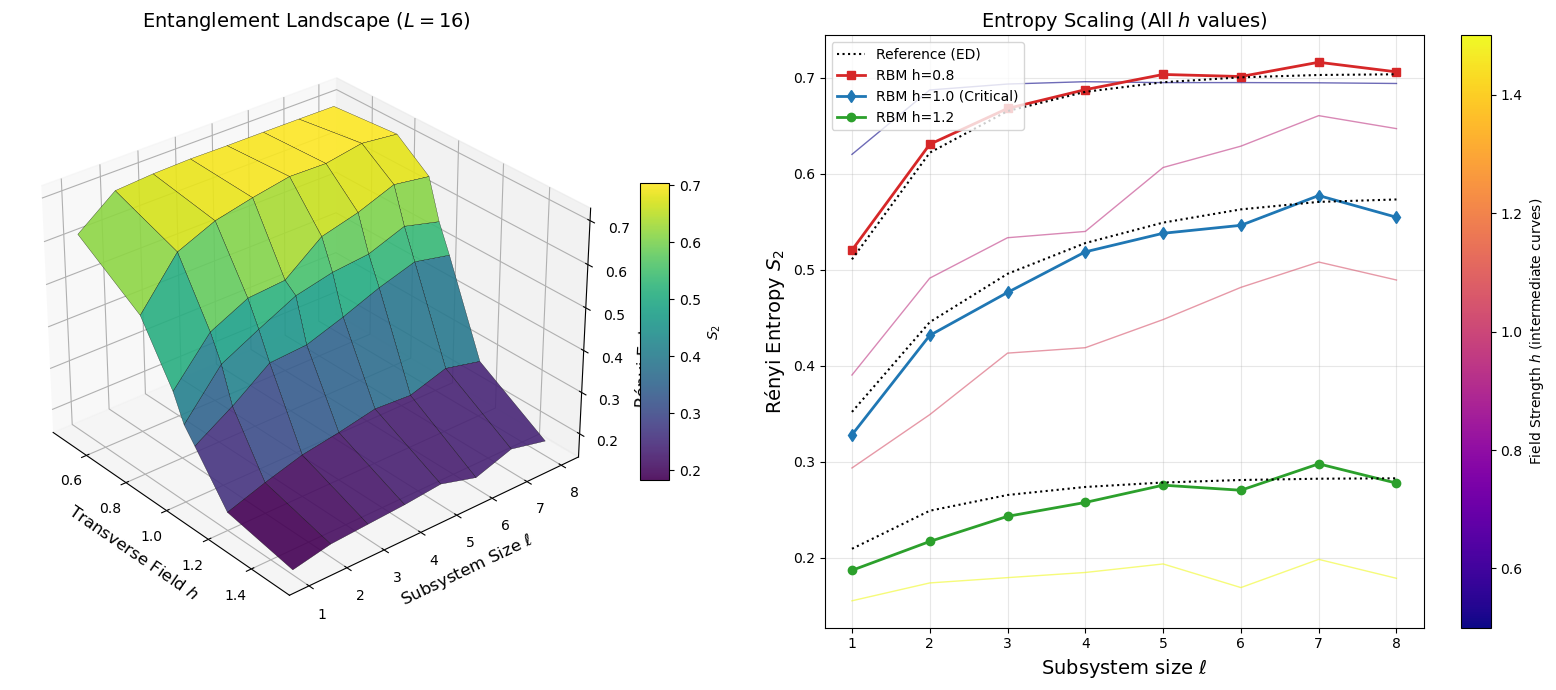

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from pathlib import Path

# --- ASSUMING PREVIOUS VARIABLES EXIST ---
# chain_length = 16
# rbm_data = { ... }  <-- Dictionary of your results
# ref_df = ...        <-- Reference dataframe
# -----------------------------------------

# 1. PREPARE DATA FOR 3D PLOT
sorted_h_keys = sorted(rbm_data.keys())

# Assuming all entries have the same length
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)

# Create Meshgrid
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 7))

# === SUBPLOT 1: 3D SURFACE ===
ax3d = fig.add_subplot(1, 2, 1, projection='3d')

# Plot surface
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, cmap='viridis',
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)

# ROTATION:
# Previous was -130. We rotate 90 degrees clockwise (subtracting 90).
# -130 - 90 = -220 (equivalent to 140).
# Or we can try -40 if you wanted the other way.
# Let's set it to -40 for a clear "Side-on" view of the h-evolution.
ax3d.view_init(elev=30, azim=-40)

fig.colorbar(surf, ax=ax3d, shrink=0.5, aspect=10, label=r'$S_2$')


# === SUBPLOT 2: 2D PROJECTION (ALL CURVES) ===
ax2d = fig.add_subplot(1, 2, 2)

# Styles for your specific comparison points
styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

# Color map for the "intermediate" curves so they look nice
# We normalize h values to pick colors from a map (e.g., 'plasma' or 'viridis')
cmap_intermediate = plt.get_cmap('plasma')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))

ref_label_added = False

for h in sorted_h_keys:

    s2_vals = rbm_data[h]
    is_special = h in styles

    # --- 1. Plot Reference (Only for special h to avoid clutter) ---
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='black', linewidth=1.5,
                      label=lbl, zorder=5) # High zorder to stay on top
            ref_label_added = True

    # --- 2. Plot RBM Data ---
    if is_special:
        # Highlighting the specific requested curves
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=st['color'], markersize=6, linewidth=2, alpha=1.0,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        # Plotting the intermediate curves (background sweep)
        # We assign a color based on h value so they form a gradient
        line_color = cmap_intermediate(norm(h))
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.6,
                  zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=14)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=14)
ax2d.set_title("Entropy Scaling (All $h$ values)", fontsize=14)

# Add a secondary colorbar for the 2D plot to explain the intermediate lines
sm = plt.cm.ScalarMappable(cmap=cmap_intermediate, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2d)
cbar.set_label('Field Strength $h$ (intermediate curves)')

ax2d.legend(frameon=True, fontsize=10, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_63032/3602410950.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


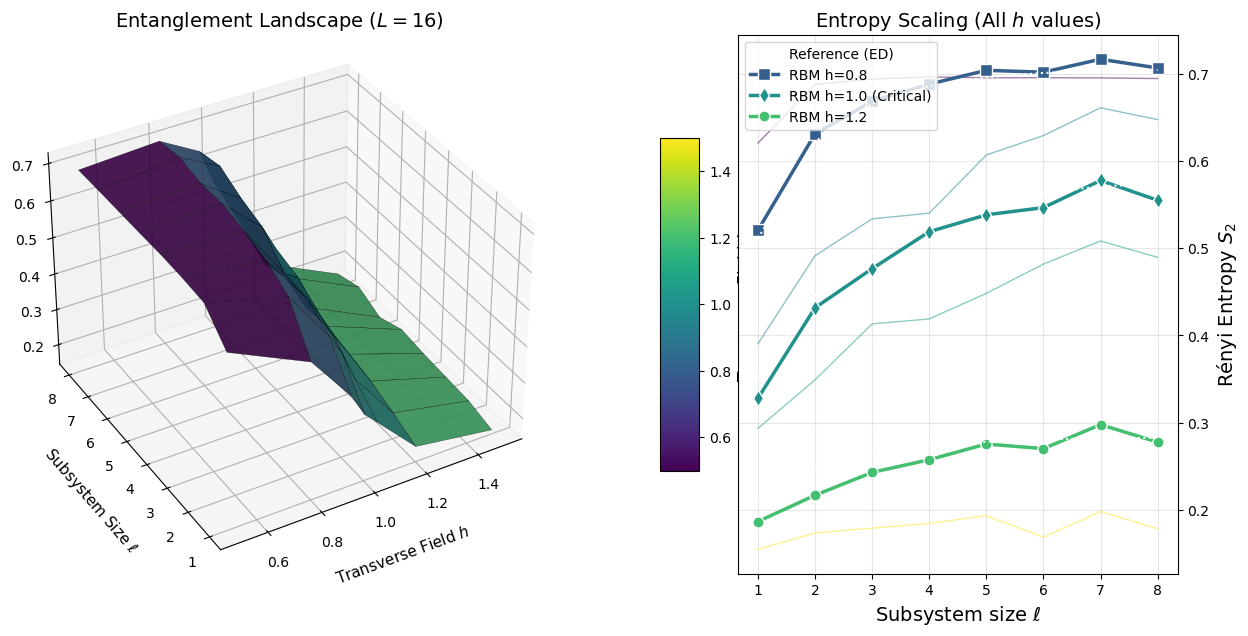

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- MOCK DATA SETUP ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. SETUP SHARED COLOR MAP
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))

# 3. FIGURE LAYOUT
fig = plt.figure(figsize=(16, 7))

# Main Grid: [3D Plot (Large)] [Colorbar Zone] [2D Plot (Small)]
gs = gridspec.GridSpec(1, 3, width_ratios=[1.4, 0.08, 0.9], wspace=0.1)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')

surface_colors = cmap(norm(X_h))
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=11, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=11, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=11, labelpad=10)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)
ax3d.view_init(elev=35, azim=-120)


# === SUBPLOT 2: CENTERED COLORBAR (Middle) ===
# Nested GridSpec to shrink the colorbar vertically
# [0.15 empty] [0.7 colorbar] [0.15 empty]
gs_cbar = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1],
                                           height_ratios=[0.15, 0.7, 0.15])
cax = fig.add_subplot(gs_cbar[1])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
# Label is placed on the left of the bar to avoid hitting the 2D plot
cbar.set_label('Transverse Field $h$', fontsize=12)


# === SUBPLOT 3: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[2])

styles = {
    0.8: {'fmt': 's', 'label': 'h=0.8'},
    1.0: {'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'fmt': 'o', 'label': 'h=1.2'}
}

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))
    is_special = h in styles

    # Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # RBM Curves
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=line_color, markersize=8, linewidth=2.5, alpha=1.0,
                  markeredgecolor='white', markeredgewidth=1,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.5, zorder=2)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=14)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=14)
ax2d.set_title("Entropy Scaling (All $h$ values)", fontsize=14)

# --- KEY CHANGE: Move Y-Axis label/ticks to the RIGHT ---
ax2d.yaxis.tick_right()
ax2d.yaxis.set_label_position("right")

ax2d.legend(frameon=True, fontsize=10, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_63032/947135378.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


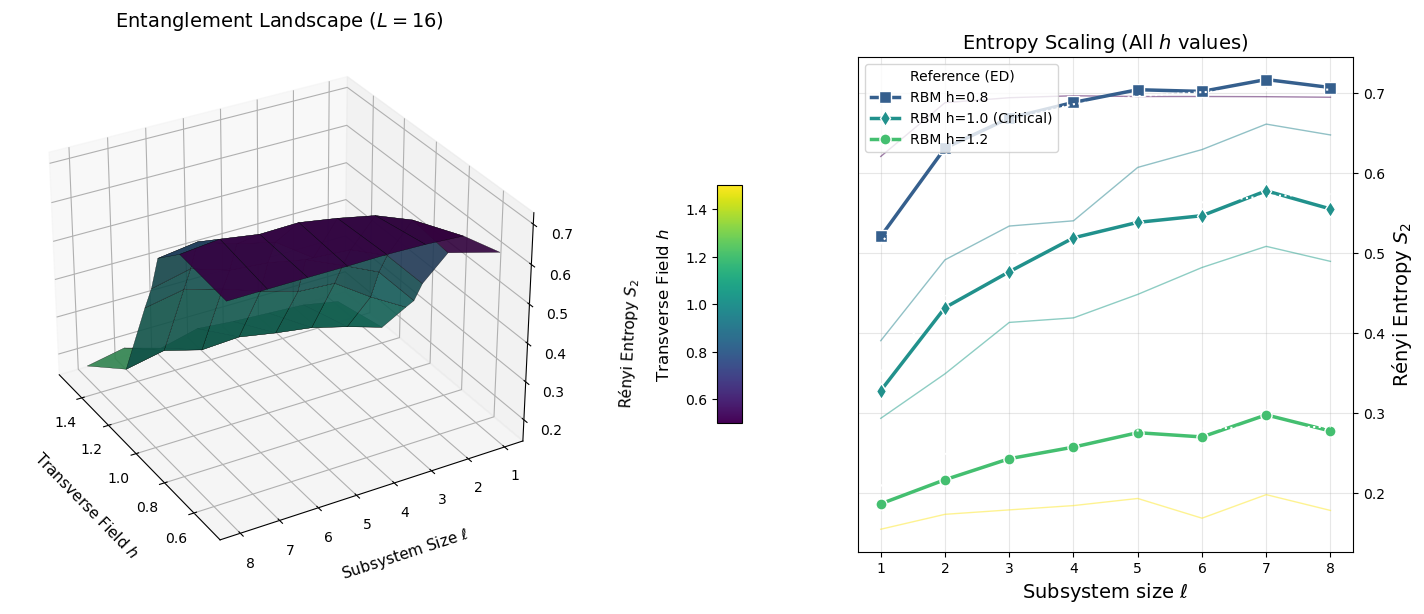

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- ASSUMING DATA EXISTS ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# ----------------------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. COLOR MAP
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))

# 3. FIGURE LAYOUT
# Made figure slightly wider to accommodate the gap
fig = plt.figure(figsize=(18, 7))

# GridSpec: [3D Plot] [Gap/Colorbar] [2D Plot]
# Increased wspace to 0.3 to push the right plot away
gs = gridspec.GridSpec(1, 3, width_ratios=[1.3, 0.05, 1.0], wspace=0.3)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')

surface_colors = cmap(norm(X_h))
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=11, labelpad=12)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=11, labelpad=12)
# Increased labelpad to fix missing Z label
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=11, labelpad=20)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)

# ROTATION: Turned 90 degrees clockwise from previous (-120 - 90 = -210)
ax3d.view_init(elev=30, azim=-210)


# === SUBPLOT 2: CENTERED COLORBAR (Middle) ===
# Using nested gridspec to control vertical height/alignment of the bar
gs_cbar = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1],
                                           height_ratios=[0.25, 0.5, 0.25])
# 0.5 middle ratio makes bar roughly legend-height
cax = fig.add_subplot(gs_cbar[1])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
# Move label to the left side of the bar so it's closer to the 3D plot it also represents
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
cbar.set_label('Transverse Field $h$', fontsize=12, labelpad=10)


# === SUBPLOT 3: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[2])

# Force the 2D plot to be Square
ax2d.set_box_aspect(1)

styles = {
    0.8: {'fmt': 's', 'label': 'h=0.8'},
    1.0: {'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'fmt': 'o', 'label': 'h=1.2'}
}

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))
    is_special = h in styles

    # Reference
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # RBM Data
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=line_color, markersize=8, linewidth=2.5, alpha=1.0,
                  markeredgecolor='white', markeredgewidth=1,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.5, zorder=2)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=14)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=14)
ax2d.set_title("Entropy Scaling (All $h$ values)", fontsize=14)

# Ticks on the right as requested
ax2d.yaxis.tick_right()
ax2d.yaxis.set_label_position("right")

ax2d.legend(frameon=True, fontsize=10, loc='upper left', bbox_to_anchor=(0, 1))
ax2d.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/v_/l0msh8452n10859t9wg_9zdc0000gq/T/ipykernel_63032/1768892013.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


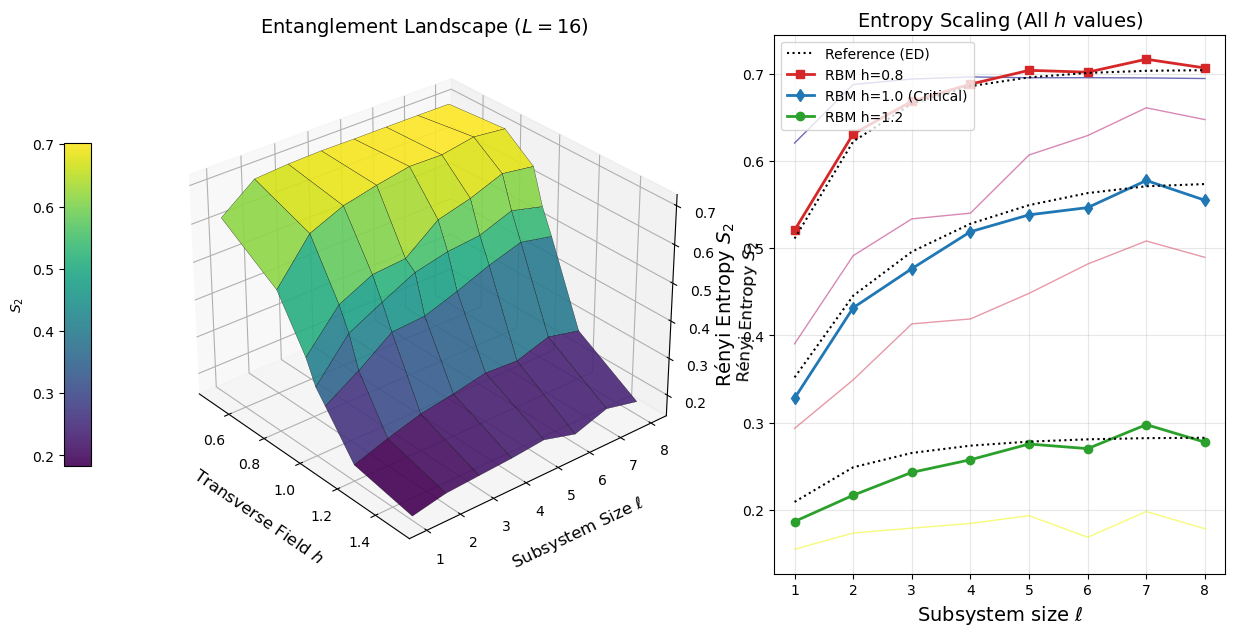

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- ASSUMING PREVIOUS VARIABLES EXIST ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------------------------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 7))

# Use GridSpec to control relative sizes
# [1.4, 0.9] makes the 3D plot significantly larger than the 2D plot
gs = gridspec.GridSpec(1, 2, width_ratios=[1.4, 0.9], wspace=0.15)

# === SUBPLOT 1: 3D SURFACE (Left - Larger) ===
ax3d = fig.add_subplot(gs[0], projection='3d')

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, cmap='viridis',
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=10)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)

# Keeping the rotation you liked
ax3d.view_init(elev=30, azim=-40)

# Colorbar moved to the LEFT
# pad controls distance from the axis, shrink controls size relative to plot
fig.colorbar(surf, ax=ax3d, location='left', shrink=0.6, aspect=12, pad=0.1, label=r'$S_2$')


# === SUBPLOT 2: 2D PROJECTION (Right - Smaller Canvas) ===
ax2d = fig.add_subplot(gs[1])

styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

# Secondary cmap just for the lines (no colorbar shown)
cmap_intermediate = plt.get_cmap('plasma')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    is_special = h in styles

    # 1. Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            # Using black for reference as in your preferred snippet
            ax2d.plot(l_values, y_ref, ':', color='black', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=st['color'], markersize=6, linewidth=2, alpha=1.0,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        line_color = cmap_intermediate(norm(h))
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.6, zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=14)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=14)
ax2d.set_title("Entropy Scaling (All $h$ values)", fontsize=14)

# No colorbar here, just the legend
ax2d.legend(frameon=True, fontsize=10, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

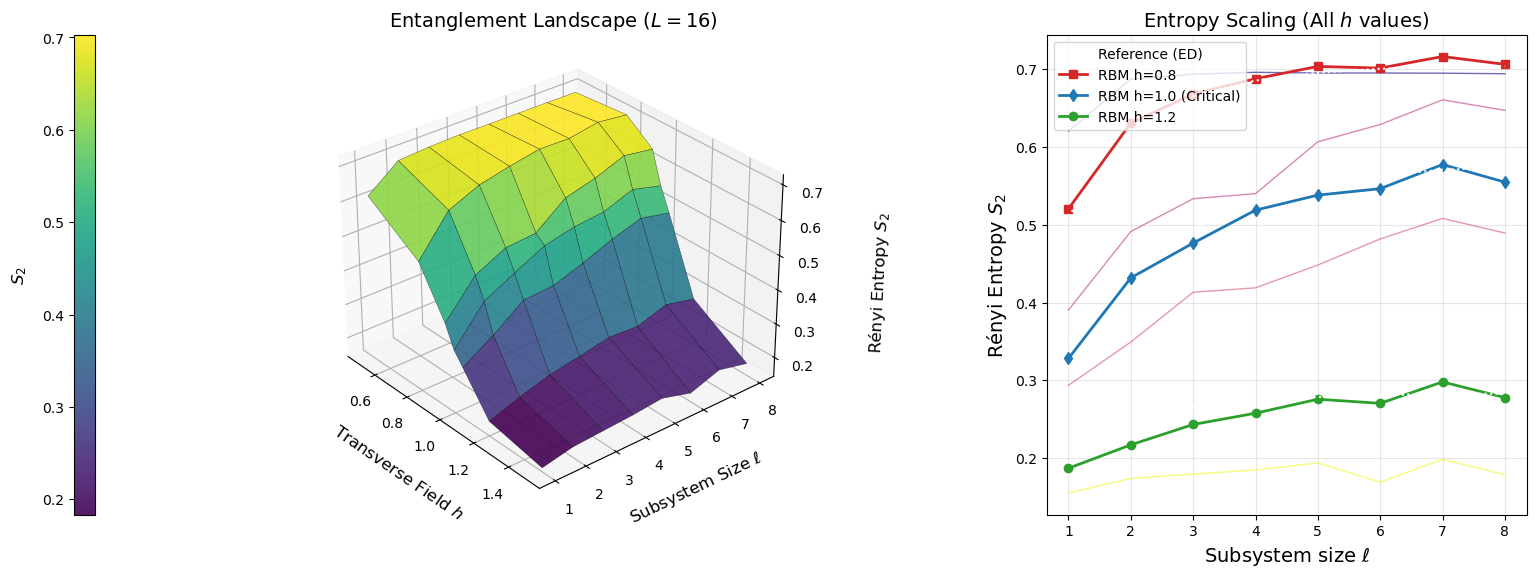

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- MOCK DATA (Ensure this matches your environment) ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# ------------------------------------------------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
# Figure height=6 is moderate to keep the square plot from looking too tiny
fig = plt.figure(figsize=(16, 6))

# GridSpec Layout:
# [Col 0: Colorbar] [Col 1: 3D Plot] [Col 2: 2D Plot]
# width_ratios=[0.03, 1.3, 0.8]:
#   - 0.03 is very thin for the colorbar so it hugs the 3D plot.
#   - 1.3 allocates space for the 3D projection.
#   - 0.8 makes the 2D plot column naturally narrower.
# wspace=0.02: practically zero gap between columns.
gs = gridspec.GridSpec(1, 3, width_ratios=[0.03, 1.3, 0.8],
                       wspace=0.02, left=0.05, right=0.98, top=0.9, bottom=0.1)

# === COL 0: COLORBAR (The "Legend" for the surface) ===
ax_cbar = fig.add_subplot(gs[0])

# === COL 1: 3D SURFACE ===
ax3d = fig.add_subplot(gs[1], projection='3d')

cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, cmap='viridis',
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
# High labelpad to avoid overlap
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=20)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)

# Rotation: Side view (-40) as preferred
ax3d.view_init(elev=30, azim=-40)

# Draw Colorbar in the thin first column
cb = plt.colorbar(surf, cax=ax_cbar)
# Move ticks/label to left
ax_cbar.yaxis.set_ticks_position('left')
ax_cbar.yaxis.set_label_position('left')
cb.set_label(r'$S_2$', fontsize=12, labelpad=10)


# === COL 2: 2D PROJECTION ===
ax2d = fig.add_subplot(gs[2])

# CRITICAL FIX: Force square aspect ratio.
# This makes the Y-dimension smaller visually to match X, creating a square.
ax2d.set_box_aspect(1)

styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

cmap_intermediate = plt.get_cmap('plasma')
ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    is_special = h in styles

    # 1. Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=st['color'], markersize=6, linewidth=2, alpha=1.0,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        line_color = cmap_intermediate(norm(h))
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.6, zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=14)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=14)
ax2d.set_title("Entropy Scaling (All $h$ values)", fontsize=14)

ax2d.legend(frameon=True, fontsize=10, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.show()

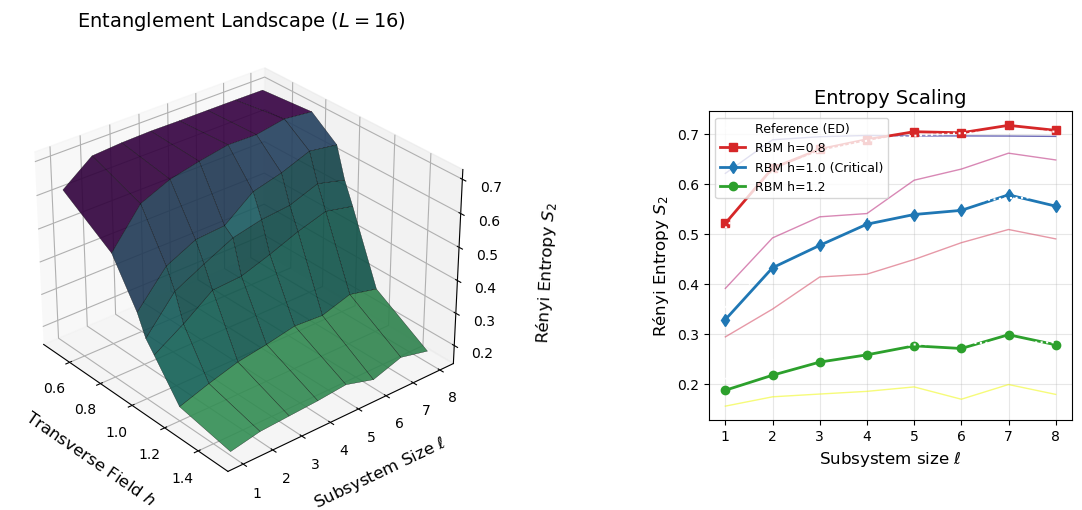

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))

# GridSpec: Two columns.
# [1.8, 0.8] makes the 3D plot much wider/larger than the 2D plot.
gs = gridspec.GridSpec(1, 2, width_ratios=[1.8, 0.8], wspace=0.1)

# === SUBPLOT 1: 3D SURFACE (Left - Large) ===
ax3d = fig.add_subplot(gs[0], projection='3d')

# Setup Colormap
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

# Plot Surface
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=15)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)

# Rotation (-40 for side view)
ax3d.view_init(elev=30, azim=-40)


# === SUBPLOT 2: 2D PROJECTION (Right - Compact) ===
ax2d = fig.add_subplot(gs[1])

# ASPECT RATIO CONTROL:
# 0.85 makes the height 85% of the width.
# This shrinks the Y-dimension physically, matching the 3D Z-axis scale better.
ax2d.set_box_aspect(0.85)

styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

cmap_intermediate = plt.get_cmap('plasma')
ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    is_special = h in styles

    # 1. Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            # White dotted line for dark background
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=st['color'], markersize=6, linewidth=2, alpha=1.0,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        line_color = cmap_intermediate(norm(h))
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.6, zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=12)
ax2d.set_title("Entropy Scaling", fontsize=14)

# Legend upper left
ax2d.legend(frameon=True, fontsize=9, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.show()

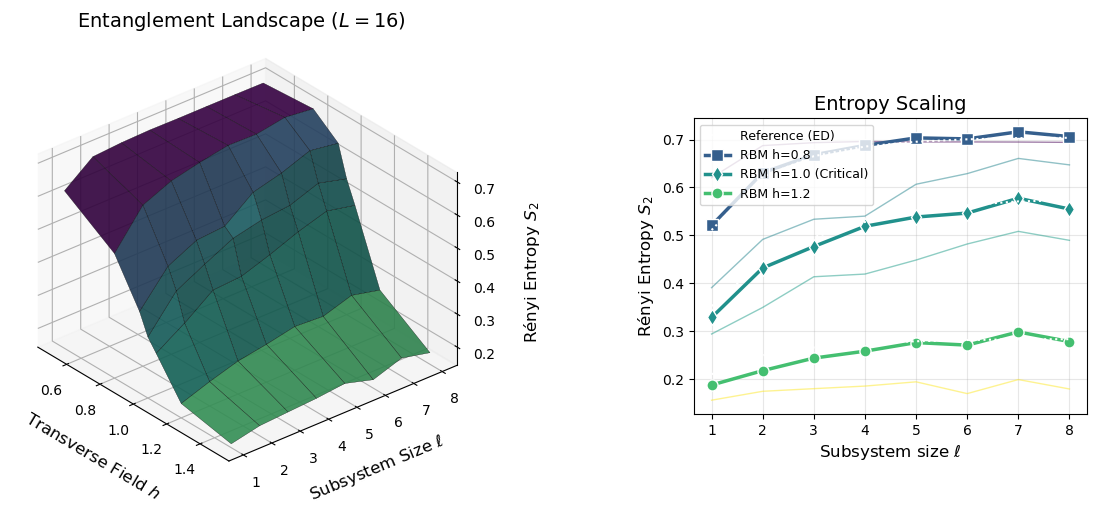

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))

# GridSpec: Left (3D) is wider [1.6], Right (2D) is narrower [0.8]
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=0.1)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')

# ISOMETRIC / ORTHOGRAPHIC PROJECTION
# This ensures parallel lines appear parallel (no perspective distortion)
ax3d.set_proj_type('ortho')

# UNIFIED COLORING: Map colors to 'h' (X_h) for both plots
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=10)
ax3d.set_title(f'Entanglement Landscape ($L={chain_length}$)', fontsize=14)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])

# SQUASH THE 2D PLOT
# 0.75 makes the plot significantly shorter in Y than X
# This matches the visual scale of the isometric 3D plot better
ax2d.set_box_aspect(0.75)

styles = {
    0.8: {'fmt': 's', 'label': 'h=0.8'},
    1.0: {'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'fmt': 'o', 'label': 'h=1.2'}
}

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]

    # Use the SHARED color map so 2D lines match 3D surface stripes
    line_color = cmap(norm(h))
    is_special = h in styles

    # 1. Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data
    if is_special:
        st = styles[h]
        # Special curves: Thicker, with markers, but SAME color logic
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=line_color, markersize=8, linewidth=2.5, alpha=1.0,
                  markeredgecolor='white', markeredgewidth=1,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        # Background curves: Thinner
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.5, zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel(r"Rényi Entropy $S_2$", fontsize=12)
ax2d.set_title("Entropy Scaling", fontsize=14)

ax2d.legend(frameon=True, fontsize=9, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.show()

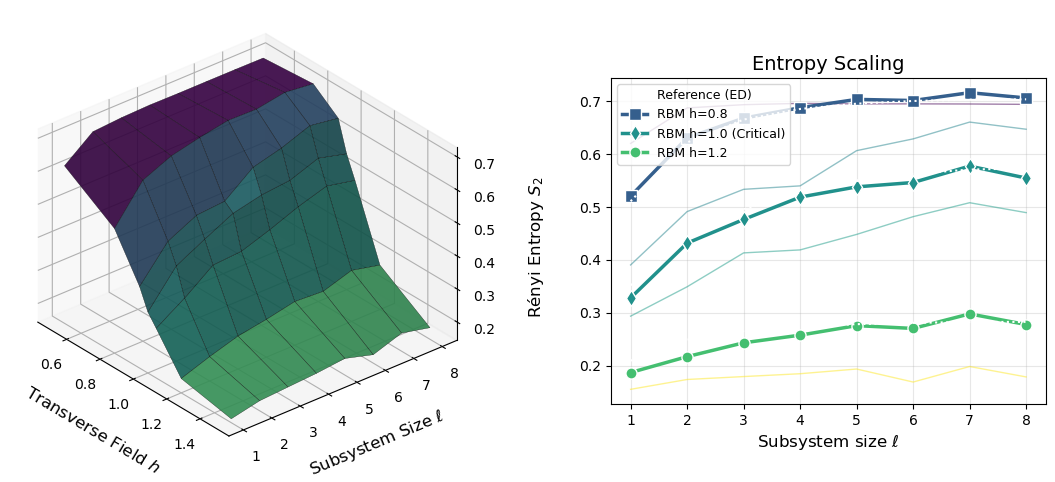

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
PLOT_WSPACE = -0.1        # Distance between the 3D and 2D plots (0.0 to 1.0)
Z_LABEL_PAD = 12         # Distance of the Z-axis label from the 3D plot
BOX_ASPECT_2D = 0.75     # Height/Width ratio of the 2D plot (smaller = flatter)
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))

# GridSpec with controllable spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho') # Isometric view

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
# Controlled Z-Label position
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)

styles = {
    0.8: {'fmt': 's', 'label': 'h=0.8'},
    1.0: {'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'fmt': 'o', 'label': 'h=1.2'}
}

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))
    is_special = h in styles

    # 1. Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=line_color, markersize=8, linewidth=2.5, alpha=1.0,
                  markeredgecolor='white', markeredgewidth=1,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.5, zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
# Removed Y-Label as requested
ax2d.set_ylabel("")
ax2d.set_title("Entropy Scaling", fontsize=14)

ax2d.legend(frameon=True, fontsize=9, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.show()

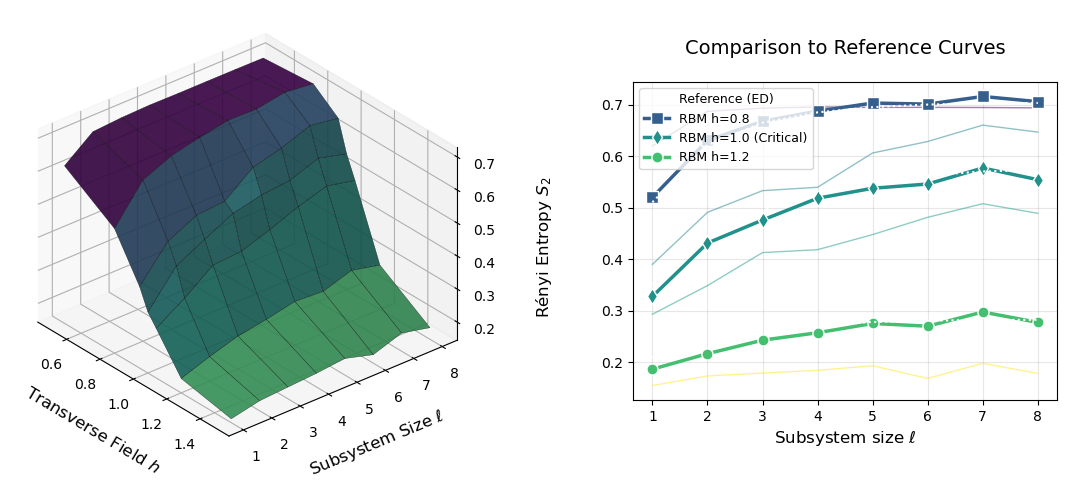

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
PLOT_WSPACE = -0.05      # Distance between the 3D and 2D plots (negative allows overlap)
Z_LABEL_PAD = 15         # Distance of the Z-axis label from the 3D plot
BOX_ASPECT_2D = 0.75     # Height/Width ratio of the 2D plot (smaller = flatter)
TITLE_PAD_2D = 20        # Vertical distance between 2D plot and its title
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))

# GridSpec with controllable spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho') # Isometric view

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
# Controlled Z-Label position
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)

styles = {
    0.8: {'fmt': 's', 'label': 'h=0.8'},
    1.0: {'fmt': 'd', 'label': 'h=1.0 (Critical)'},
    1.2: {'fmt': 'o', 'label': 'h=1.2'}
}

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))
    is_special = h in styles

    # 1. Reference (ED)
    if ref_df is not None and is_special:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, ':', color='white', linewidth=1.5, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data
    if is_special:
        st = styles[h]
        ax2d.plot(l_values, s2_vals, marker=st['fmt'], linestyle='-',
                  color=line_color, markersize=8, linewidth=2.5, alpha=1.0,
                  markeredgecolor='white', markeredgewidth=1,
                  label=f"RBM {st['label']}", zorder=4)
    else:
        ax2d.plot(l_values, s2_vals, marker=None, linestyle='-',
                  color=line_color, linewidth=1.0, alpha=0.5, zorder=2)


ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
# Removed Y-Label as requested
ax2d.set_ylabel("")

# --- TITLE WITH CONTROLLED PADDING ---
# 'pad' moves the text up (in points) without moving the axes/canvas
ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

ax2d.legend(frameon=True, fontsize=9, loc='upper left')
ax2d.grid(True, alpha=0.3)

plt.show()

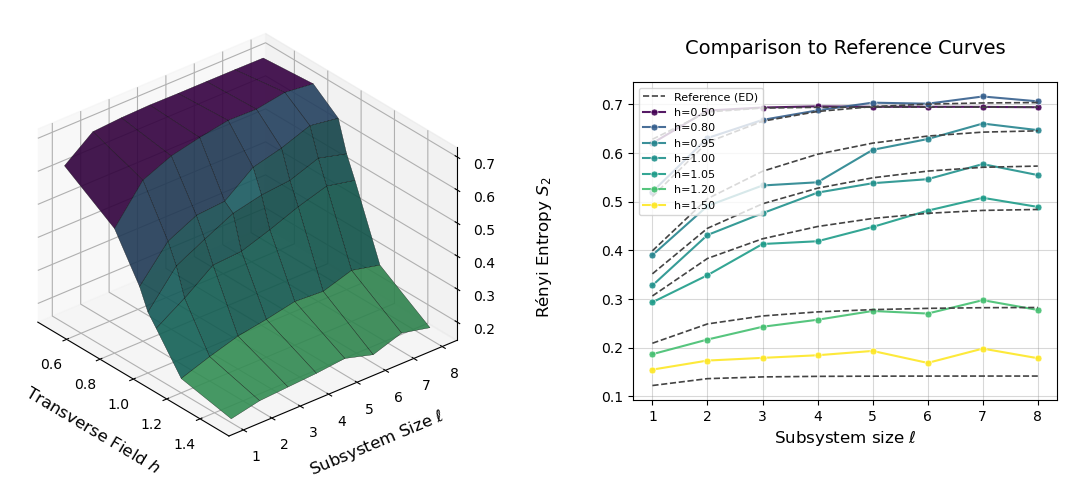

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
PLOT_WSPACE = -0.05      # Distance between the 3D and 2D plots
Z_LABEL_PAD = 15         # Distance of the Z-axis label from the 3D plot
BOX_ASPECT_2D = 0.75     # Height/Width ratio of the 2D plot
TITLE_PAD_2D = 20        # Vertical distance between 2D plot and its title
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))

# FORCE WHITE BACKGROUND
fig.patch.set_facecolor('white')

# GridSpec with controllable spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho') # Isometric view

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')
ax2d.set_box_aspect(BOX_ASPECT_2D)

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))

    # 1. Reference (ED) - Plot for ALL h if available
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            # Label only the first one to avoid clogging legend
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"

            # Plot: Black/Dark Gray, Dashed
            ax2d.plot(l_values, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data - Uniform Style for ALL curves
    # Round markers ('o'), colored by h
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")

# Title with padding
ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

# Legend: Might be large if many h values, place outside or keep small
ax2d.legend(frameon=True, fontsize=8, loc='upper left', ncol=1)
ax2d.grid(True, alpha=0.3, color='gray')

plt.show()

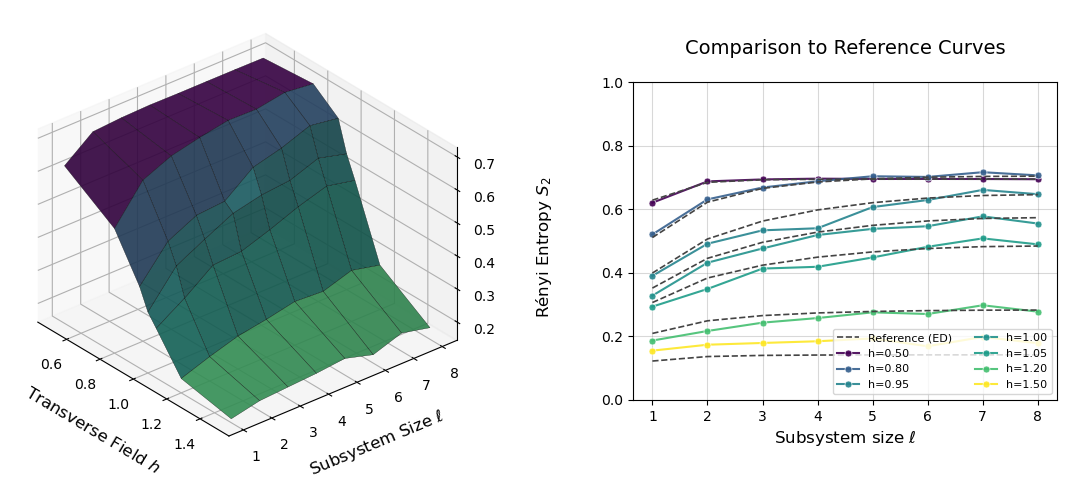

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
PLOT_WSPACE = -0.05      # Distance between the 3D and 2D plots
Z_LABEL_PAD = 15         # Distance of the Z-axis label from the 3D plot
BOX_ASPECT_2D = 0.75     # Height/Width ratio of the 2D plot
TITLE_PAD_2D = 20        # Vertical distance between 2D plot and its title
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white') # Force white background

# GridSpec with controllable spacing
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho') # Isometric view

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')
ax2d.set_box_aspect(BOX_ASPECT_2D)

# FORCE Y-AXIS TO START AT 0
ax2d.set_ylim(bottom=0)

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))

    # 1. Reference (ED) - Plot for ALL h if available
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"

            # Plot: Dark Gray, Dashed
            ax2d.plot(l_values, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # 2. RBM Data - Round markers ('o') for everything
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")

ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

# Legend: Bottom Right, 2 Columns
ax2d.legend(frameon=True, fontsize=8, loc='lower right', ncol=2)
ax2d.grid(True, alpha=0.3, color='gray')

plt.show()

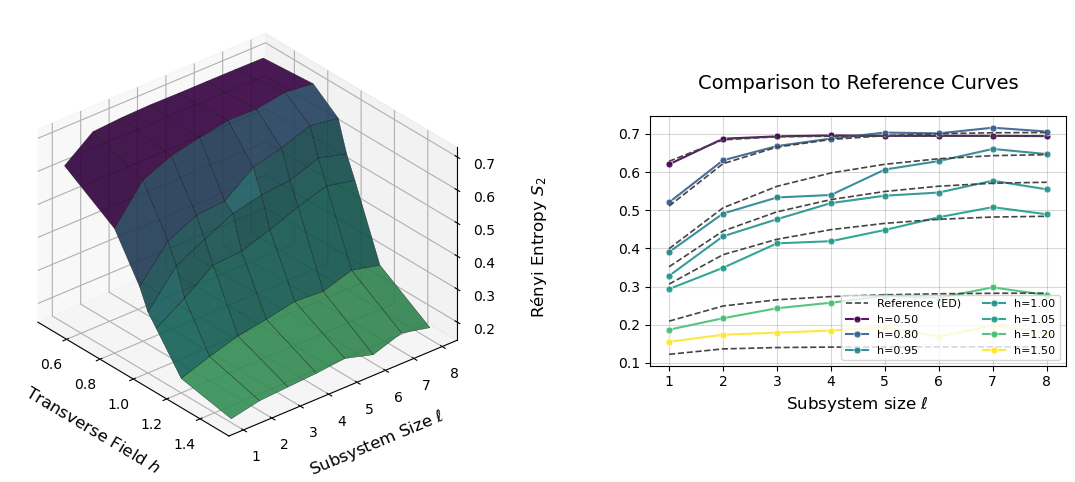

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
# Layout Controls
PLOT_WSPACE = -0.01        # Distance between the 3D and 2D plots
VERTICAL_OFFSET_2D = 0.0   # Move 2D plot Up (+) or Down (-) (e.g., 0.05 or -0.05)

# 2D Plot Geometry
BOX_ASPECT_2D = 0.6       # Height/Width ratio (smaller = flatter)
Y_MAX_2D = 0.7             # Maximum value for Y-axis (Caps the graph)

# Styling/Labels
Z_LABEL_PAD = 13           # Distance of Z-label from 3D plot
TITLE_PAD_2D = 20          # Distance of title from 2D plot
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white')

# GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho')

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')

# 1. Apply Aspect Ratio
ax2d.set_box_aspect(BOX_ASPECT_2D)

# 2. Apply Vertical Shift (Manual Position Adjustment)
pos = ax2d.get_position()
# shift y-bottom and y-top by the offset
new_pos = [pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height]
ax2d.set_position(new_pos)

# 3. Apply Y-Axis Limits (0 to Y_MAX_2D)
#ax2d.set_ylim(0, Y_MAX_2D + 0.05)

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))

    # Reference (ED)
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # RBM Data
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")

ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

# Legend: Bottom Right, 2 Columns
ax2d.legend(frameon=True, fontsize=8, loc='lower right', ncol=2)
ax2d.grid(True, alpha=0.3, color='gray')

plt.show()

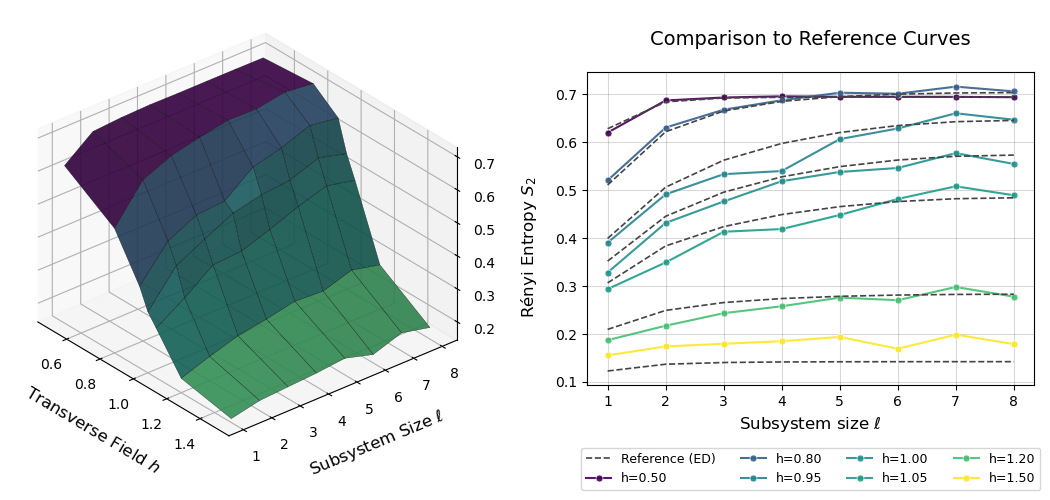

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
# Layout Controls
PLOT_WSPACE = -0.15        # Distance between the 3D and 2D plots
VERTICAL_OFFSET_2D = 0.02   # Move 2D plot Up (+) or Down (-)

# 2D Plot Geometry
BOX_ASPECT_2D = 0.7        # Height/Width ratio (smaller = flatter)
Y_MAX_2D = 0.7             # Maximum value for Y-axis (Caps the graph)

# Styling/Labels
Z_LABEL_PAD = 9           # Distance of Z-label from 3D plot
TITLE_PAD_2D = 20          # Distance of title from 2D plot

# Legend Controls
LEGEND_NCOL = 4            # Number of columns
LEGEND_X = 0.5             # Horizontal position (0.5 = centered relative to axes)
LEGEND_Y = -0.18           # Vertical position (negative = below x-axis)
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white')

# GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho')

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor='k', linewidth=0.2, alpha=0.9)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')

# 1. Apply Aspect Ratio
ax2d.set_box_aspect(BOX_ASPECT_2D)

# 2. Apply Vertical Shift (Manual Position Adjustment)
pos = ax2d.get_position()
new_pos = [pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height]
ax2d.set_position(new_pos)

# 3. Apply Y-Axis Limits (Optional cap)
# ax2d.set_ylim(0, Y_MAX_2D)

ref_label_added = False

for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))

    # Reference (ED)
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # RBM Data
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")

ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

# LEGEND: Placed outside using bbox_to_anchor
ax2d.legend(frameon=True, fontsize=9,
            loc='upper center',                   # Anchor point on the legend box
            bbox_to_anchor=(LEGEND_X, LEGEND_Y),  # Position relative to the axes
            ncol=LEGEND_NCOL)

ax2d.grid(True, alpha=0.3, color='gray')

plt.show()

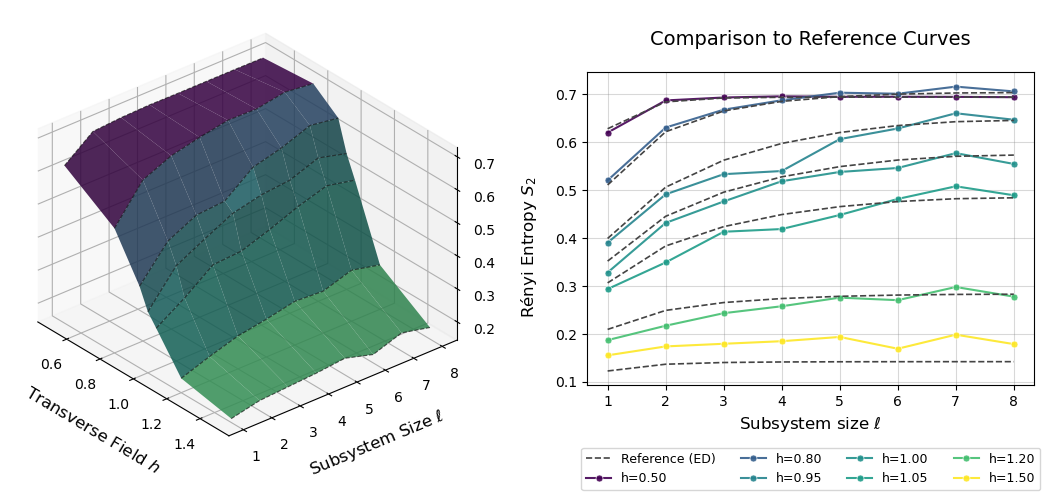

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
# Layout Controls
PLOT_WSPACE = -0.15        # Distance between the 3D and 2D plots
VERTICAL_OFFSET_2D = 0.02   # Move 2D plot Up (+) or Down (-)

# 2D Plot Geometry
BOX_ASPECT_2D = 0.7        # Height/Width ratio (smaller = flatter)
Y_MAX_2D = 0.7             # Maximum value for Y-axis (Caps the graph)

# Styling/Labels
Z_LABEL_PAD = 9            # Distance of Z-label from 3D plot
TITLE_PAD_2D = 20          # Distance of title from 2D plot

# Legend Controls
LEGEND_NCOL = 4            # Number of columns
LEGEND_X = 0.5             # Horizontal position (0.5 = centered relative to axes)
LEGEND_Y = -0.18           # Vertical position (negative = below x-axis)
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white')

# GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho')

# Unified Color Map
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap(norm(X_h))

# Plot the colored surface background
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor=None, linewidth=0, alpha=0.85)
# Note: I removed grid lines from surface (linewidth=0)
# to make the black dashed lines popping out more clearly

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')

# 1. Apply Aspect Ratio
ax2d.set_box_aspect(BOX_ASPECT_2D)

# 2. Apply Vertical Shift
pos = ax2d.get_position()
new_pos = [pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height]
ax2d.set_position(new_pos)

# 3. Apply Y-Axis Limits (Optional cap)
# ax2d.set_ylim(0, Y_MAX_2D)

ref_label_added = False


for h in sorted_h_keys:
    s2_vals = rbm_data[h]
    line_color = cmap(norm(h))

    # --- 3D PLOTTING: Add Black Dashed Lines on Surface ---
    # We construct the 3D coordinates for this specific h curve
    xs_3d = np.full_like(l_values, h, dtype=float)
    ys_3d = l_values
    zs_3d = s2_vals
    # Plot on ax3d
    ax3d.plot(xs_3d, ys_3d, zs_3d, color='black', linestyle='--',
              linewidth=0.8, alpha=0.6, zorder=10)
    # ------------------------------------------------------

    # --- 2D PLOTTING: Reference (ED) ---
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # --- 2D PLOTTING: RBM Data ---
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")

ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

# LEGEND
ax2d.legend(frameon=True, fontsize=9,
            loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y),
            ncol=LEGEND_NCOL)

ax2d.grid(True, alpha=0.3, color='gray')

plt.show()

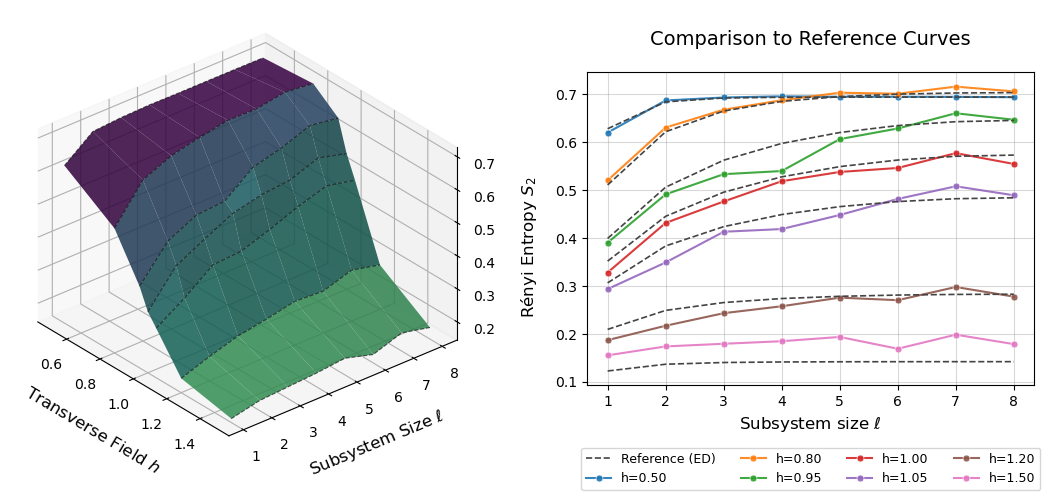

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
# Layout Controls
PLOT_WSPACE = -0.15        # Distance between the 3D and 2D plots
VERTICAL_OFFSET_2D = 0.02   # Move 2D plot Up (+) or Down (-)

# 2D Plot Geometry
BOX_ASPECT_2D = 0.7        # Height/Width ratio (smaller = flatter)
Y_MAX_2D = 0.7             # Maximum value for Y-axis (Caps the graph)

# Styling/Labels
Z_LABEL_PAD = 9            # Distance of Z-label from 3D plot
TITLE_PAD_2D = 20          # Distance of title from 2D plot

# Legend Controls
LEGEND_NCOL = 4            # Number of columns
LEGEND_X = 0.5             # Horizontal position (0.5 = centered relative to axes)
LEGEND_Y = -0.18           # Vertical position (negative = below x-axis)
# -------------------------------

# --- MOCK DATA ---
# chain_length = 16
# rbm_data = { ... }
# ref_df = ...
# -----------------

# 1. PREPARE DATA
sorted_h_keys = sorted(rbm_data.keys())
l_values = np.arange(1, len(rbm_data[sorted_h_keys[0]]) + 1)
X_h, Y_l = np.meshgrid(sorted_h_keys, l_values)
Z_s2 = np.zeros_like(X_h, dtype=float)

for i, l_val in enumerate(l_values):
    for j, h_val in enumerate(sorted_h_keys):
        Z_s2[i, j] = rbm_data[h_val][i]

# 2. PLOTTING
fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white')

# GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho')

# Unified Color Map (Viridis for 3D Surface)
cmap_surface = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=min(sorted_h_keys), vmax=max(sorted_h_keys))
surface_colors = cmap_surface(norm(X_h))

# Plot the colored surface background
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor=None, linewidth=0, alpha=0.85)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')

# 1. Apply Aspect Ratio
ax2d.set_box_aspect(BOX_ASPECT_2D)

# 2. Apply Vertical Shift
pos = ax2d.get_position()
new_pos = [pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height]
ax2d.set_position(new_pos)

# 3. Define Tab10 Color Cycle for 2D Model Lines
cmap_2d_cycle = plt.get_cmap("tab10")

ref_label_added = False

for i, h in enumerate(sorted_h_keys):
    s2_vals = rbm_data[h]

    # CHANGE: Use tab10 color based on index
    line_color = cmap_2d_cycle(i % 10)

    # --- 3D PLOTTING: Add Black Dashed Lines on Surface (Unchanged) ---
    xs_3d = np.full_like(l_values, h, dtype=float)
    ys_3d = l_values
    zs_3d = s2_vals
    ax3d.plot(xs_3d, ys_3d, zs_3d, color='black', linestyle='--',
              linewidth=0.8, alpha=0.6, zorder=10)
    # ------------------------------------------------------------------

    # --- 2D PLOTTING: Reference (ED) (Unchanged - Dark Gray Dashed) ---
    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(l_values, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # --- 2D PLOTTING: RBM Data (Changed to use line_color from tab10) ---
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")

ax2d.set_title("Comparison to Reference Curves", fontsize=14, pad=TITLE_PAD_2D)

# LEGEND
ax2d.legend(frameon=True, fontsize=9,
            loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y),
            ncol=LEGEND_NCOL)

ax2d.grid(True, alpha=0.3, color='gray')

plt.show()